In [1]:
import pandas as pd
import numpy as np


date_local1 = pd.read_excel('ElectricDate/台区标识1000967005.xlsx')
date_local2 = pd.read_excel('ElectricDate/台区标识1000970901.xlsx')

print("date_local.shape: ", date_local1.shape, date_local2.shape)

def Dateloader(DateFrame, axis_in_date, input_size):
    date = DateFrame.values[:,axis_in_date]
    date = date.reshape(-1, 365)
    num_user = date.shape[0]
    train_date = np.array([[]]*input_size).T
    test_date = np.array([[]]*input_size).T
    # print(date[:, 1:1+10].shape)
    split_point = int(365*0.8)
    for i in range(0, split_point-input_size+1):
        # print(i, date[:, i:i+input_size].shape)
        train_date = np.vstack([train_date, date[:, i:i+input_size]])
    
    for i in range(split_point, 365-input_size+1):
        # print(i, date[:, i:i+input_size].shape)
        test_date = np.vstack([test_date, date[:, i:i+input_size]])
    
    # train_date = date_time_window_split[0:int(date_time_window_split.shape[0]*e0.8), :]
    # test_date = date_time_window_split[int(date_time_window_split.shape[0]*0.8):, :]
    
    print("train_date.shape: ", train_date.shape, "test_date.shape: ", test_date.shape)

    return train_date, test_date, num_user


traindate_1_1, testdate_1_1, num_user1 = Dateloader(date_local1, 1, 10)
traindate_1_2, testdate_1_2, _ = Dateloader(date_local1, 2, 10)
traindate_1_3, testdate_1_3, _ = Dateloader(date_local1, 3, 10)
traindate_1_4, testdate_1_4, _ = Dateloader(date_local1, 4, 10)

traindate_2_1, testdate_2_1, num_user2 = Dateloader(date_local2, 1, 10)
traindate_2_2, testdate_2_2, _= Dateloader(date_local2, 2, 10)
traindate_2_3, testdate_2_3, _ = Dateloader(date_local2, 3, 10)
traindate_2_4, testdate_2_4, _ = Dateloader(date_local2, 4, 10)

# print(testdate_1_1[0])
# print(testdate_1_1[-1])


date_local.shape:  (45625, 6) (48545, 6)
train_date.shape:  (35375, 10) test_date.shape:  (8000, 10)
train_date.shape:  (35375, 10) test_date.shape:  (8000, 10)
train_date.shape:  (35375, 10) test_date.shape:  (8000, 10)
train_date.shape:  (35375, 10) test_date.shape:  (8000, 10)
train_date.shape:  (37639, 10) test_date.shape:  (8512, 10)
train_date.shape:  (37639, 10) test_date.shape:  (8512, 10)
train_date.shape:  (37639, 10) test_date.shape:  (8512, 10)
train_date.shape:  (37639, 10) test_date.shape:  (8512, 10)


In [6]:
# 从时间窗口划分后的数据还原
def redate_local(date, input_size, num_user):
    origin_date = np.array([[]]*num_user)
    # print("origin_date.shape: ", origin_date.shape)

    for i in range(0, int(date.shape[0]/num_user)):
        # print(date[i*num_user:(i+1)*num_user,:].shape)
        origin_date = np.hstack([origin_date, date[i*num_user:(i+1)*num_user,:]])
    # print("origin_date.shape: ",origin_date.shape)

    date_ = origin_date[:, 0:input_size]
    # print(date_.shape)
    for i in range(2*input_size-1, origin_date.shape[1], input_size):
        date_ = np.hstack([date_, origin_date[:, i:i+1]])
    
    print("恢复数据shape", date_.shape)
    # print(date_[0])

    # date_ = date_.reshape(-1, 1)
    return date_

In [7]:
testdate_1_1.shape

(8000, 10)

In [8]:
testdate_huifu1_1 = redate_local(testdate_1_1, 10, num_user1)
testdate_huifu1_2 = redate_local(testdate_1_2, 10, num_user1)
testdate_huifu1_3 = redate_local(testdate_1_3, 10, num_user1)
testdate_huifu1_4 = redate_local(testdate_1_4, 10, num_user1)
testdate_huifu2_1 = redate_local(testdate_2_1, 10, num_user2)
testdate_huifu2_2 = redate_local(testdate_2_2, 10, num_user2)
testdate_huifu2_3 = redate_local(testdate_2_3, 10, num_user2)
testdate_huifu2_4 = redate_local(testdate_2_4, 10, num_user2)

恢复数据shape (125, 73)
恢复数据shape (125, 73)
恢复数据shape (125, 73)
恢复数据shape (125, 73)
恢复数据shape (133, 73)
恢复数据shape (133, 73)
恢复数据shape (133, 73)
恢复数据shape (133, 73)


In [14]:
# Optimization the denoising autoencoder by genetic algorithm for anomaly detection (DAEGA)

np.random.seed(0)

input_size = 10
hidden_size = 5
num_epoch = 1

# 迭代次数
num_generations = 100
# 染色体长度
chr_size = 2*input_size + input_size*hidden_size*2 + hidden_size
# 每个群落中染色体的数量
chr_per_pop = 100 
# 定义群落规模，(染色体数量，染色体长度).
population_size = (chr_per_pop, chr_size)
# 初始化群落.
new_population = np.random.uniform(low=-1.0, high=1.0, size=population_size)
# 群落中精英染色体数量
num_parents_mating = 30

# 交配得到的下一代基因来自父染色体的概率
p = 0.5
# 每条染色变异基因的最大数量（不能大于chr_size）
num_mutation = int(chr_size * 0.1)


# 降噪自编码器
# 输入：染色体和输入x
# 输出：x重构后的数据y
def DAE(chromosome, input):

    noise = chromosome[0 : input_size]
    inputAddNoise = input + noise

    w_index1 = input_size + input_size*hidden_size
    w_index2 = w_index1 + hidden_size*input_size
    b_index1 = w_index2 + hidden_size
    b_index2 = b_index1 + input_size

    w_in_to_hidden = chromosome[input_size : w_index1].reshape(hidden_size, input_size)
    w_hidden_to_out = chromosome[w_index1 : w_index2].reshape(input_size, hidden_size)
    b_in_to_hidden = chromosome[w_index2 : b_index1]
    b_hidden_to_out = chromosome[b_index1 : b_index2]

    # print("inputAddNoise: ", inputAddNoise)
    # print("w_in_to_hidden: ", w_in_to_hidden)
    # print("w_hidden_to_out: ", w_hidden_to_out)
    # print("b_in_to_hidden: ", b_in_to_hidden)
    # print("b_hidden_to_out: ", b_hidden_to_out)

    hidden = relu(np.dot(w_in_to_hidden, inputAddNoise) + b_in_to_hidden)
    # print("w_in_to_hidden*inputAddNoise: ", np.dot(w_in_to_hidden, inputAddNoise))
    # print("hidden: ",hidden)
    output = relu(np.dot(w_hidden_to_out, hidden) + b_hidden_to_out)

    return output

def relu(array):
    return np.maximum(array, 0)

# 计算适应度，即输入x与x重构后的y直接的距离，这个值越小表示染色体越好
def col_pop_fitness(x, pop):
    fitness = []
    for i in range(chr_per_pop):
        chr = pop[i, :] # 染色体
        y = DAE(chr, x)
        dist = np.sqrt(np.sum(np.square(x - y)))
        fitness.append(dist)
    fitness = np.array(fitness)
    return fitness

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best chromosome in the current generation as parents for producting the offspring of the next generation.
    parents = np.empty((num_parents, chr_size))
    for parent_num in range(num_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents[parent_num, :] = pop[min_fitness_idx, :]
        fitness[min_fitness_idx] = float('inf')
    return parents

# 给精英染色体和交配得到的子代规模(染色体总数量-精英染色体数量, 染色体长度)
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = np.random.randint(0, parents.shape[0])
        # Index of the second parent to mate
        parent2_idx = np.random.randint(0, parents.shape[0])

        is_from_a = np.random.random(chr_size) < p
        offspring[k, :] = np.where(is_from_a, parents[parent1_idx, :], parents[parent2_idx, :])

    return offspring

def mutation(offspring_crossover):
    # Mutation changes some gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, num_mutation)
        offspring_crossover[idx, np.random.randint(0, chr_size, num_mutation)] = random_value
    return offspring_crossover

def train(date):

    # batch_avg_fitness_list = []

    for batch in range(num_epoch):

        # batch_fitness = []

        for idx, x in enumerate(date):

            # 计算适应度
            fitness = col_pop_fitness(x, new_population)

            # 在群落中选择适应度最小的染色体做为精英.
            parents = select_mating_pool(new_population, fitness, num_parents_mating)

            # 通过交配生成下一代.
            offspring_crossover = crossover(parents, offspring_size=(population_size[0]-parents.shape[0], chr_size))

            # 基因变异.
            offspring_mutation = mutation(offspring_crossover)

            # 得到下一代.
            new_population[0:parents.shape[0], :] = parents
            new_population[parents.shape[0]:, :] = offspring_mutation

            fitness = col_pop_fitness(x, new_population)
            # batch_fitness.append(np.min(fitness))

            if idx%15000 == 0: 
                print("Generation : ", idx)
                print("Best result : ", np.min(fitness))

        # Getting the best solution after iterating finishing all generation
        # At first, the fitness is calculated for each solution in the final generation
        
        fitness = col_pop_fitness(x, new_population)
        # batch_avg_fitness = np.mean(batch_fitness)
        # batch_avg_fitness_list.append(batch_avg_fitness)

        # Then return the index of the solution corresponding the best fitness
        best_match_idx = np.where(fitness == np.min(fitness))[0][0]
        best_chromosome = new_population[best_match_idx, :]
        # print("Best_match_idx : ", best_match_idx)
        # print("Best solution : ", best_chromosome)
        print("Best solution fitness : ", fitness[best_match_idx])

    # plt.plot(range(len(batch_avg_fitness_list)), batch_avg_fitness_list)
    # plt.show()
    return best_chromosome


In [11]:
def predict(traindate, test_date):

    best_chromosome = train(date=traindate)

    test_date_after = np.array([[]]*input_size).T
    # print(test_date_after.shape)
    for i in test_date:
        new_i = DAE(best_chromosome, i)
        new_i = np.array(new_i).reshape(1,10)
        test_date_after = np.vstack([test_date_after, new_i])   

    print("test_date_after.shape: ", test_date_after.shape)

    return test_date_after
    


In [15]:
test_date_after1_1 = predict(traindate_1_1, testdate_1_1)
test_date_after1_2 = predict(traindate_1_2, testdate_1_2)
test_date_after1_3 = predict(traindate_1_3, testdate_1_3)
test_date_after1_4 = predict(traindate_1_4, testdate_1_4)

test_date_after2_1 = predict(traindate_2_1, testdate_2_1)
test_date_after2_2 = predict(traindate_2_2, testdate_2_2)
test_date_after2_3 = predict(traindate_2_3, testdate_2_3)
test_date_after2_4 = predict(traindate_2_4, testdate_2_4)

Generation :  0
Best result :  0.8891010232695079
Generation :  15000
Best result :  0.8063438823142752
Generation :  30000
Best result :  0.9836807945079709
Best solution fitness :  2.011494389597685
test_date_after.shape:  (8000, 10)
Generation :  0
Best result :  0.33647660232869175
Generation :  15000
Best result :  0.6200159603740303
Generation :  30000
Best result :  0.9657996703821833
Best solution fitness :  1.4711907175338783
test_date_after.shape:  (8000, 10)
Generation :  0
Best result :  1.3951796573392863
Generation :  15000
Best result :  1.3642543639519342
Generation :  30000
Best result :  1.133361152964602
Best solution fitness :  2.3327073674055248
test_date_after.shape:  (8000, 10)
Generation :  0
Best result :  0.599492627718404
Generation :  15000
Best result :  0.5847008671080155
Generation :  30000
Best result :  0.9341873326964123
Best solution fitness :  1.994902864483705
test_date_after.shape:  (8000, 10)
Generation :  0
Best result :  0.5894207459763958
Gener

In [16]:
testdate_predict1_1 = redate_local(test_date_after1_1, 10, num_user1)
testdate_predict1_2 = redate_local(test_date_after1_2, 10, num_user1)
testdate_predict1_3 = redate_local(test_date_after1_3, 10, num_user1)
testdate_predict1_4 = redate_local(test_date_after1_4, 10, num_user1)

testdate_predict2_1 = redate_local(test_date_after2_1, 10, num_user2)
testdate_predict2_2 = redate_local(test_date_after2_2, 10, num_user2)
testdate_predict2_3 = redate_local(test_date_after2_3, 10, num_user2)
testdate_predict2_4 = redate_local(test_date_after2_4, 10, num_user2)

恢复数据shape (125, 73)
恢复数据shape (125, 73)
恢复数据shape (125, 73)
恢复数据shape (125, 73)
恢复数据shape (133, 73)
恢复数据shape (133, 73)
恢复数据shape (133, 73)
恢复数据shape (133, 73)


In [17]:
import matplotlib.pyplot as plt

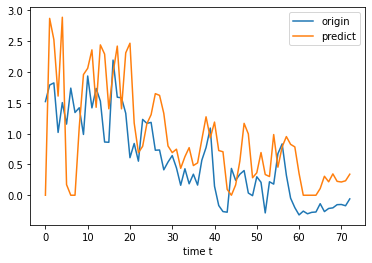

In [25]:
# plt.figure(figsize = (18,12))
x = range(0,len(testdate_predict1_1[0,:]))
y1_1 = testdate_huifu1_1[70,:].tolist()
prey1_1 = testdate_predict1_1[70,:].tolist()
# y1_2 = testdate_huifu1_2[70,:].tolist()
# prey1_2 = testdate_predict1_2[70,:].tolist()
plt.plot(x, y1_1, label='origin')
plt.plot(x, prey1_1, label='predict')
# plt.plot(x, y1_2, label='origin 2')
# plt.plot(x, prey1_2, label='predict 2')
plt.xlabel('time t')
plt.legend()
# plt.savefig('picture/'+str(i)+'.png')

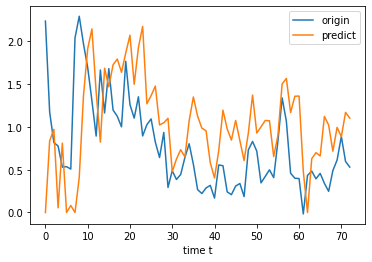

In [33]:
# plt.figure(figsize = (18,12))
plt.cla()
x = range(0,len(testdate_predict1_1[0,:]))
y1_1 = testdate_huifu1_1[82,:].tolist()
prey1_1 = testdate_predict1_1[82,:].tolist()
# y1_2 = testdate_huifu1_2[70,:].tolist()
# prey1_2 = testdate_predict1_2[70,:].tolist()
plt.plot(x, y1_1, label='origin')
plt.plot(x, prey1_1, label='predict')
# plt.plot(x, y1_2, label='origin 2')
# plt.plot(x, prey1_2, label='predict 2')
plt.xlabel('time t')
plt.legend()
# plt.savefig('picture/'+str(i)+'.png')

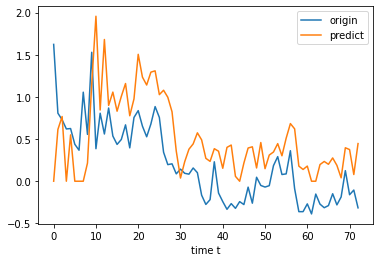

In [34]:
# plt.figure(figsize = (18,12))
plt.cla()
x = range(0,len(testdate_predict1_1[0,:]))
y1_1 = testdate_huifu1_1[98,:].tolist()
prey1_1 = testdate_predict1_1[98,:].tolist()
# y1_2 = testdate_huifu1_2[70,:].tolist()
# prey1_2 = testdate_predict1_2[70,:].tolist()
plt.plot(x, y1_1, label='origin')
plt.plot(x, prey1_1, label='predict')
# plt.plot(x, y1_2, label='origin 2')
# plt.plot(x, prey1_2, label='predict 2')
plt.xlabel('time t')
plt.legend()
# plt.savefig('picture/'+str(i)+'.png')

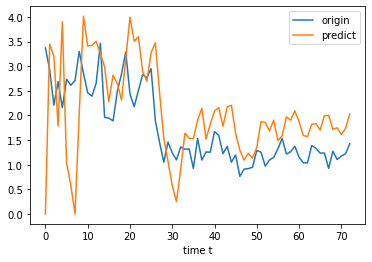

In [35]:
# plt.figure(figsize = (18,12))
plt.cla()
x = range(0,len(testdate_predict1_1[0,:]))
y1_1 = testdate_huifu1_1[102,:].tolist()
prey1_1 = testdate_predict1_1[102,:].tolist()
# y1_2 = testdate_huifu1_2[70,:].tolist()
# prey1_2 = testdate_predict1_2[70,:].tolist()
plt.plot(x, y1_1, label='origin')
plt.plot(x, prey1_1, label='predict')
# plt.plot(x, y1_2, label='origin 2')
# plt.plot(x, prey1_2, label='predict 2')
plt.xlabel('time t')
plt.legend()
# plt.savefig('picture/'+str(i)+'.png')

In [36]:
testdate_huifu1_1.shape

(125, 73)

In [37]:
testdate_predict1_1.shape

(125, 73)

In [42]:
test1_origin_col1 = testdate_huifu1_1.reshape(-1,1)
test1_origin_col2 = testdate_huifu1_2.reshape(-1,1)
test1_origin_col3 = testdate_huifu1_3.reshape(-1,1)
test1_origin_col4 = testdate_huifu1_4.reshape(-1,1)

test1_origin = np.hstack([test1_origin_col1, test1_origin_col2, test1_origin_col3, test1_origin_col4])
print("test1_origin.shape", test1_origin.shape)


test1_predict_col1 = testdate_predict1_1.reshape(-1,1)
test1_predict_col2 = testdate_predict1_2.reshape(-1,1)
test1_predict_col3 = testdate_predict1_3.reshape(-1,1)
test1_predict_col4 = testdate_predict1_4.reshape(-1,1)

test1_predict = np.hstack([test1_predict_col1, test1_predict_col2, test1_predict_col3, test1_predict_col4])
print("test1_predict.shape", test1_predict.shape)

test1_origin.shape (9125, 4)
test1_predict.shape (9125, 4)


In [43]:
test2_origin_col1 = testdate_huifu2_1.reshape(-1,1)
test2_origin_col2 = testdate_huifu2_2.reshape(-1,1)
test2_origin_col3 = testdate_huifu2_3.reshape(-1,1)
test2_origin_col4 = testdate_huifu2_4.reshape(-1,1)

test2_origin = np.hstack([test2_origin_col1, test2_origin_col2, test2_origin_col3, test2_origin_col4])
print("test2_origin.shape", test2_origin.shape)


test2_predict_col1 = testdate_predict2_1.reshape(-1,1)
test2_predict_col2 = testdate_predict2_2.reshape(-1,1)
test2_predict_col3 = testdate_predict2_3.reshape(-1,1)
test2_predict_col4 = testdate_predict2_4.reshape(-1,1)

test2_predict = np.hstack([test2_predict_col1, test2_predict_col2, test2_predict_col3, test2_predict_col4])
print("test2_predict.shape", test2_predict.shape)

test2_origin.shape (9709, 4)
test2_predict.shape (9709, 4)


In [45]:
def distance(x, y):
    distance = []
    for i, j in zip(x, y):
        dist = np.sqrt(np.sum(np.square(i - j)))
        distance.append(dist)
    return distance

In [50]:
distance1 = distance(test1_origin, test1_predict)
distance2 = distance(test2_origin, test2_predict)

print(len(distance1), len(distance2))

9125 9709


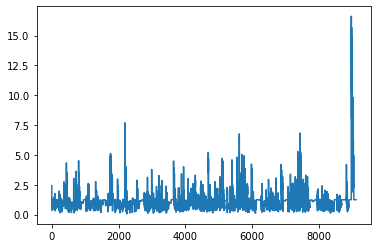

In [49]:
plt.cla()
plt.plot(range(len(distance1)), distance1)

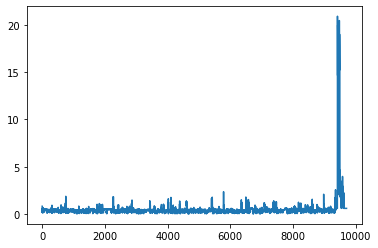

In [51]:
plt.cla()
plt.plot(range(len(distance2)), distance2)

In [71]:
def datetrans(distance_arr, label_thre, threshold):
    distance_arr = np.array(distance_arr)
    label = np.array([0]*len(distance_arr))
    y = np.array([0]*len(distance_arr))

    label[distance_arr < label_thre] = 1
    y[distance_arr < threshold] = 1
    return label, y

In [86]:
from sklearn.metrics import accuracy_score, f1_score, precision_score,roc_curve

def getmatrix(x, y):
    acc = accuracy_score(x,y)
    f1 = f1_score(x, y)
    pre = precision_score(x, y)
    print("accuracy is: ", acc)
    print("f1 score is: ", f1)
    print("precision is: ", pre)

In [87]:
label1, y1 = datetrans(distance1, 1.4, 5)
label2, y2 = datetrans(distance2, 0.55, 5)

getmatrix(label1, y1)
getmatrix(label2, y2)

accuracy is:  0.8832876712328767
f1 score is:  0.9376354160566844
precision is:  0.8825928784037042
accuracy is:  0.892161911628386
f1 score is:  0.9425577440061448
precision is:  0.8913562311922798


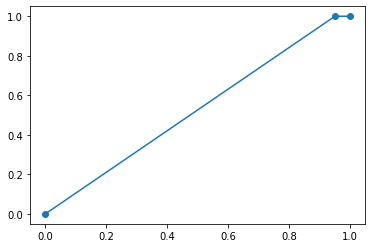

In [89]:
fpr, tpr, thresholds = roc_curve(label1, y1, pos_label=1)
plt.cla()
plt.plot(fpr,tpr,marker = 'o')